In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
            device = '/gpu:9'
    except RuntimeError as e:
        print(e)

print("device", device)

2024-08-08 18:42:47.193088: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 18:42:47.257139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 18:42:47.304299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 18:42:47.317237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 18:42:47.366487: I tensorflow/core/platform/cpu_feature_guar

device /gpu:9


In [2]:
import h5py
import numpy as np
# Load HDF5 data
h5_filename = '/home/da886/ElectronCountingProject/500KImagesForOverfitting_smaller_negative paddings.h5'
with h5py.File(h5_filename, 'r') as f:
    images = np.array(f['images'][:300000])
    centers = np.array(f['centers_training'][:300000])

In [3]:
image_normalized = (images + 1e-9) / 20


images_np = image_normalized
center_coordinates = centers / [1,64, 64]  # Normalizing the center coordinates
probabilities = center_coordinates[:,:, :-2]
probabilities = tf.expand_dims(probabilities, axis=1)
center_coordinates_np = center_coordinates[:, :, 1:]
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
batch_size = 800
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))

2024-08-08 18:42:58.577381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 9, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:cf:00.0, compute capability: 8.0


In [4]:
center_coordinates_np.shape,probabilities.shape

(TensorShape([300000, 1, 12, 2]), TensorShape([300000, 1, 12, 1]))

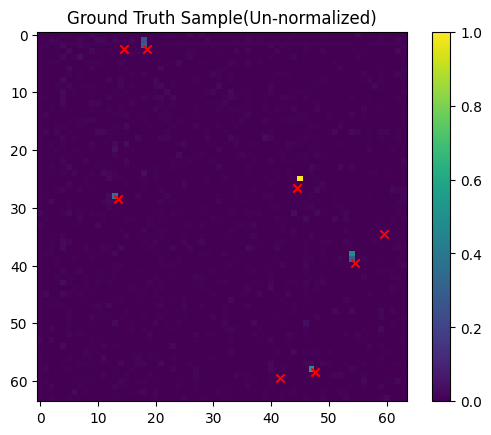

In [4]:
import matplotlib.pyplot as plt
a = np.random.randint(0, len(images))
# a =2
image = images[a]
centerss = centers[a]

# Plot the image with valid centers
plt.imshow(image, )
valid_centers = centerss[centerss[:, 0] == 1]
for center in valid_centers:
    plt.scatter(center[1], center[2], c='red', marker='x')  # Note: center[1] is x and center[2] is y
plt.title('Ground Truth Sample(Un-normalized)')
plt.colorbar()
plt.show()


In [6]:
#### 
d = np.random.randint(0, len(centers))
# d= 2
centers[d]

array([[ 1. , 33.5, 40.5],
       [ 1. , 11.5,  5.5],
       [ 1. , 58.5, 29.5],
       [ 1. , 56.5, 58.5],
       [ 1. ,  1.5, 61.5],
       [ 1. , 11.5, 53.5],
       [ 1. , 55.5, 47.5],
       [ 0. , -1. , -1. ],
       [ 0. , -1. , -1. ],
       [ 0. , -1. , -1. ],
       [ 0. , -1. , -1. ],
       [ 0. , -1. , -1. ]], dtype=float32)

In [5]:
np.max(images), np.min(images), np.mean(images), np.std(images)

(255, 0, 0.7403353556315104, 4.895689923293382)

In [6]:
np.max(images_np), np.min(images_np), np.mean(images_np), np.std(images_np)

(12.75000000005, 5e-11, 0.03701676783159355, 0.2447844961646714)

In [8]:
np.max(centers),np.min(centers)

(63.5, -1.0)

In [9]:
np.max(center_coordinates_np),np.min(center_coordinates_np)

(0.9921875, -0.015625)

In [10]:
p = np.random.randint(0,len(center_coordinates_np))
center_coordinates_np[p],probabilities[p]

(<tf.Tensor: shape=(1, 12, 2), dtype=float64, numpy=
 array([[[ 0.2265625,  0.6953125],
         [ 0.9921875,  0.4765625],
         [ 0.1953125,  0.6953125],
         [ 0.8828125,  0.6484375],
         [ 0.5078125,  0.6171875],
         [ 0.1953125,  0.7734375],
         [ 0.5546875,  0.1484375],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ]]])>,
 <tf.Tensor: shape=(1, 12, 1), dtype=float64, numpy=
 array([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]])>)

In [7]:
total_items = len(images_np)
train_size = int(total_items * 0.8)
val_size = total_items - train_size 

    # Splitting the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size) 

In [8]:
dataset,train_dataset,val_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(64, 64), dtype=tf.float64, name=None), {'x_prob_reshape': TensorSpec(shape=(1, 12, 1), dtype=tf.float64, name=None), 'x_midpoints_reshape': TensorSpec(shape=(1, 12, 2), dtype=tf.float64, name=None)})>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64), dtype=tf.float64, name=None), {'x_prob_reshape': TensorSpec(shape=(None, 1, 12, 1), dtype=tf.float64, name=None), 'x_midpoints_reshape': TensorSpec(shape=(None, 1, 12, 2), dtype=tf.float64, name=None)})>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64), dtype=tf.float64, name=None), {'x_prob_reshape': TensorSpec(shape=(None, 1, 12, 1), dtype=tf.float64, name=None), 'x_midpoints_reshape': TensorSpec(shape=(None, 1, 12, 2), dtype=tf.float64, name=None)})>)

Custom Loss

In [10]:
@tf.keras.utils.register_keras_serializable()
class MaskedMeanSquaredError(tf.keras.losses.Loss): 
    def __init__(self, name="masked_mse_loss", mask_value=-1, **kwargs):
        super().__init__(name=name, **kwargs)
        self.mask_value = mask_value

    def call(self, y_true, y_pred):
        # Create mask based on mask_value
        mask = tf.not_equal(y_true, self.mask_value)
        mask = tf.cast(mask, tf.float32)
        
        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate mean squared error
        mse = tf.reduce_mean(tf.square(y_true_masked - y_pred_masked), axis=-1)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(mse) / mask_sum
        return masked_loss



@tf.keras.utils.register_keras_serializable()
class MaskedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, name="masked_binary_crossentropy", mask_value=0, **kwargs):
        super().__init__(name=name, **kwargs)
        self.mask_value = mask_value

    def call(self, y_true, y_pred):
        # Create mask based on mask_value
        mask = tf.not_equal(y_true, self.mask_value)
        mask = tf.cast(mask, tf.float32)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true_masked, y_pred_masked)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(bce) / mask_sum
        return masked_loss



In [11]:
from tensorflow.keras import layers, models, regularizers, optimizers, losses

input_shape = (64, 64, 1)
num_classes = 12
num_coordinates = 2

x_input = layers.Input(shape=input_shape)

# Layer 1
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)

# Layer 2
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Layer 3
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Layer 4
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

# Layer 5
x = layers.Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)

# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1,num_classes, 1), name='x_prob_reshape')(x_prob)

# Midpoint output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='tanh', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1,num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)

model = models.Model(inputs=x_input, outputs=[x_prob_reshape, x_midpoints_reshape])

optimizer = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss={
    'x_prob_reshape': MaskedBinaryCrossentropy(),
    'x_midpoints_reshape': MaskedMeanSquaredError()
})

# Summarize the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      2,560 │ input_layer_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_9[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    147,520 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │     73,792 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 8, 8, 64)  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 8, 8, 64)  │    102,464 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 4, 4, 64)  │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │                   │            │                 

 Total params: 1,360,548 (5.19 MB)

 Trainable params: 1,359,908 (5.19 MB)

 Non-trainable params: 640 (2.50 KB)

In [12]:
x_input.shape,x.shape,x_prob.shape,x_prob_reshape.shape,x_midpoints.shape,x_midpoints_reshape.shape

((None, 64, 64, 1),
 (None, 1024),
 (None, 12),
 (None, 1, 12, 1),
 (None, 24),
 (None, 1, 12, 2))

In [25]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 50  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/Weights from my data/early stopping with tanh/model_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming your existing model and datasets are already defined

# Train the model and capture the history
num_epochs = 30
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    
)

Epoch 1/30


I0000 00:00:1723142669.309261 3506402 service.cc:146] XLA service 0x7f0e4c015670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723142669.309331 3506402 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-08 18:44:29.389634: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-08 18:44:29.745568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-08 18:44:50.256480: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[800,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[800,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_qu

300/300 ━━━━━━━━━━━━━━━━━━━━ 167s 278ms/step - loss: 0.1071 - val_loss: 0.8436
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - loss: 0.0268 - val_loss: 0.1675
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - loss: 0.0260 - val_loss: 0.0443
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - loss: 0.0255 - val_loss: 0.0439
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - loss: 0.0250 - val_loss: 0.0442
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - loss: 0.0245 - val_loss: 0.0437
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 234ms/step - loss: 0.0243 - val_loss: 0.0417
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - loss: 0.0241 - val_loss: 0.0315
Epoch 9/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 0.0239 - val_loss: 0.0350
Epoch 10/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 0.0238 - val_loss: 0.0327
Epoch 11/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - loss: 0.0237 - val_loss: 0.0290
Epoch 12/30
300/300 ━━━━━━━━━

dict_keys(['loss', 'val_loss'])


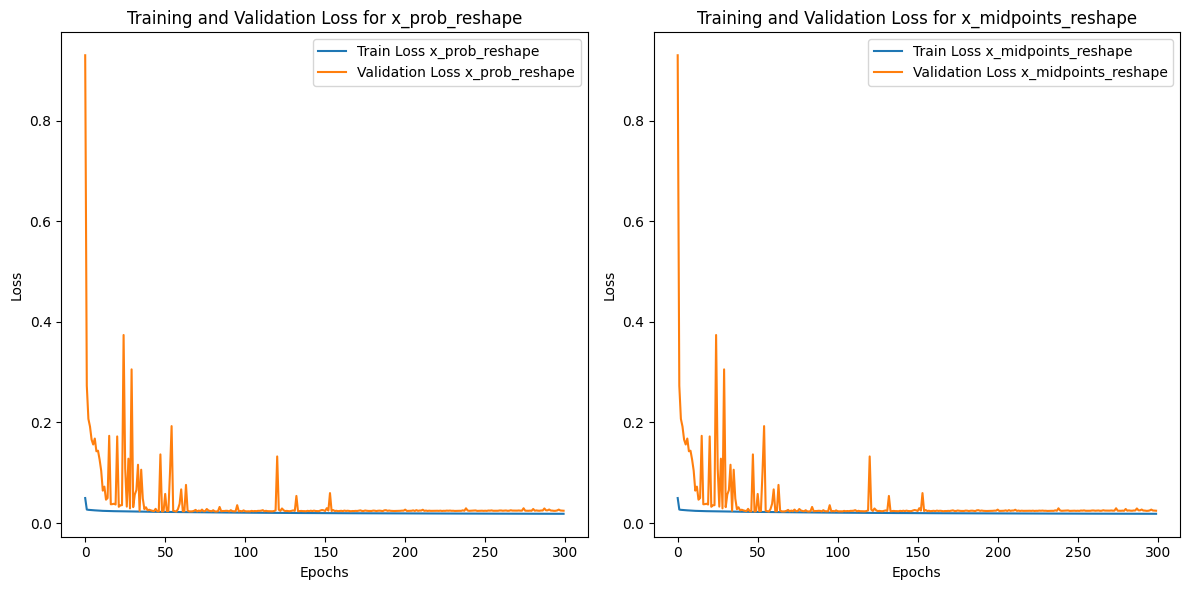

In [27]:


# Print the available keys in the history
print(history.history.keys())

# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If there are specific losses for x_prob and x_midpoints, extract them
train_loss_x_prob = history.history.get('x_prob_reshape_loss', train_loss)
val_loss_x_prob = history.history.get('val_x_prob_reshape_loss', val_loss)
train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)


# Plot the training and validation losses
plt.figure(figsize=(12, 6))

# Plotting x_prob_reshape loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_x_prob, label='Train Loss x_prob_reshape')
plt.plot(val_loss_x_prob, label='Validation Loss x_prob_reshape')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for x_prob_reshape')
plt.legend()

# Plotting x_midpoints_reshape loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for x_midpoints_reshape')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
model.save('/home/da886/ElectronCountingProject/Weights from my data/early stopping weights/tanhfor500KImages_masked.keras')

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
train_dataset = dataset.take(train_size)
train_dataset = train_dataset.batch(100)
# test_dataset = dataset.take(val_size)
# test_dataset = test_dataset.batch(100)
inputs,targets = next(iter(train_dataset))
# inputs,targets = next(iter(test_dataset))
output =model.predict(inputs)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [29]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = MaskedMeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 0.016438108


In [30]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_prob_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[0], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = MaskedBinaryCrossentropy()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("Binary Crossentropy Loss:", mse_loss.numpy())

Binary Crossentropy Loss: 2.713818e-07


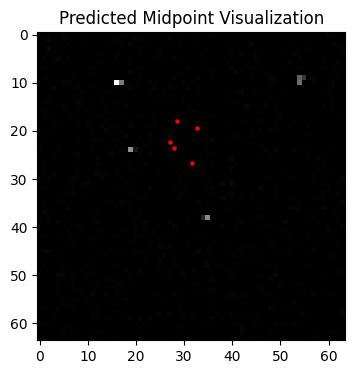

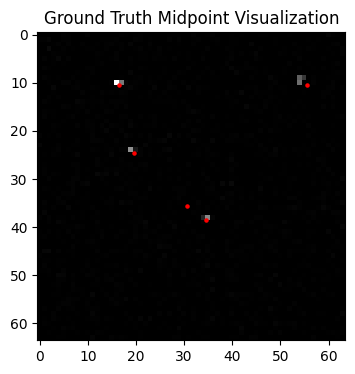

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (p,u) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(p, u, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()
    
    

t = np.random.randint(0,100)
# t=11
visualize_midpoints(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   

def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (x,y) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(x, y, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(targets['x_midpoints_reshape'][t,0,:,:])*[64,64]) ##ground truth          




In [90]:
tf.square(-0.2-0)

NameError: name 'x_midpoints_reshape_loss' is not defined